 Objetivo do Notebook
1. importação e preparação das bases
2. Treinamento do Modelo de Classificação
3. Análise Técnica de Performance (Base de Teste)
4. Análise Financeira (AS-IS vs TO-BE)
5. Escoragem da Base Out-of-Time

In [20]:
# ================================
# Bibliotecas básicas
# ================================
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Métricas
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

# Configurações
pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid")


In [21]:
from pathlib import Path

# Caminho base do projeto (a partir do notebook)
BASE_PATH = Path("..").resolve()
DATA_PATH = BASE_PATH / "data" / "final"

# Carregamento das bases
df_train = pd.read_parquet(DATA_PATH / "train.parquet")
df_test  = pd.read_parquet(DATA_PATH / "test.parquet")
df_oot   = pd.read_parquet(DATA_PATH / "oot.parquet")

# Verificação básica
print(f"Treino: {df_train.shape}")
print(f"Teste:  {df_test.shape}")
print(f"OOT:    {df_oot.shape}")


Treino: (120750, 70)
Teste:  (51751, 70)
OOT:    (91965, 69)


In [22]:
set(df_test.columns) - set(df_train.columns)

set()

In [23]:
set(df_train.columns) - set(df_test.columns)


set()

In [24]:
# Checagem de colunas principais
assert "ID" in df_train.columns
assert "TARGET" in df_train.columns

# Conferir consistência de schema
assert set(df_train.columns) == set(df_test.columns)
assert set(df_train.drop(columns=["TARGET"], errors="ignore").columns) == \
       set(df_oot.columns)

df_train.head()


,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR12,VAR14,VAR15,VAR18,VAR19,VAR22,VAR24,VAR25,VAR32,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR141,VAR142,VAR147,VAR148,ID,VAR16_missing_flag,VAR148_has_EMAIL_INEXISTENTE,VAR148_has_NOME_INEXISTENTE,VAR148_has_CEP_INEXISTENTE,VAR148_has_SUCESSO,VAR148_num_inconsistencias,NUM_CAMPOS_MISSING_PADRAO,SOMA_RISCO_66_101,MEDIA_RISCO_66_101,SOMA_DISTANCIA_102_140,MEDIA_DISTANCIA_102_140,QTD_DISTANCIA_INFORMADA_102_140,IDADE_MISSING,VAR11_MISSING,VAR12_MISSING,VAR14_MISSING,VAR15_MISSING,VAR18_MISSING,VAR19_MISSING,VAR22_MISSING,VAR24_MISSING,VAR25_MISSING,VAR42_MISSING
0,2017-06-01 00:00:00+00:00,0,M,34.137,RO,-8.808779,-63.878470,D,E,BAIXA,1.0,0.182,0.141,0.112,1.263014,1.142466,0.125,0.034,0.000,NAO_INFORMADO,0.512334,0.486768,0.357526,0.538737,0.046,S,N,N,N,N,N,N,N,N,N,N,N,S,N,N,N,N,2680.289259,D,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,181755,0,1,1,1,0,3,4,117.0,3.250000,137.0,3.512821,39,0,0,0,0,1,0,1,1,0,1,0
1,2017-08-18 00:00:00+00:00,0,M,40.447,PB,-7.146537,-34.926080,E,E,MEDIA,0.0,0.159,0.136,0.127,0.654795,1.545205,0.125,0.017,0.000,NAO_INFORMADO,0.328021,0.447454,0.414335,0.485512,0.099,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,1777.725469,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,287633,1,1,1,1,0,3,1,136.0,3.777778,124.0,3.179487,39,0,0,1,0,0,0,0,0,0,0,0
2,2017-06-30 00:00:00+00:00,0,F,33.515,RS,-27.900178,-53.314035,None,E,ALTISSIMA,0.0,0.095,0.152,0.112,1.665753,1.142466,0.125,0.000,0.000,NAO_INFORMADO,0.627262,0.730539,0.916771,0.519726,1.000,S,N,N,N,N,N,N,S,N,N,N,N,N,N,S,N,N,1695.494979,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,88015,0,1,1,1,0,3,6,43.0,1.194444,175.0,4.487179,39,0,1,0,0,1,0,1,1,0,1,0
3,2017-08-05 00:00:00+00:00,1,F,25.797,BA,-12.948874,-38.451863,E,E,MEDIA,0.0,0.359,0.014,0.112,0.619178,1.142466,0.125,0.000,0.000,NAO_INFORMADO,0.338643,0.405233,0.408007,0.567710,0.000,S,S,N,N,N,N,S,S,N,N,N,N,N,N,N,N,N,1399.037809,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,122576,1,1,1,1,0,3,4,174.0,4.833333,115.0,2.948718,39,0,0,0,0,1,0,1,1,0,1,0
4,2017-07-29 00:00:00+00:00,0,F,54.074,RS,-30.051810,-51.213277,B,E,MEDIA,2.0,0.736,0.207,0.181,1.816438,2.090411,0.250,0.000,0.032,NAO_INFORMADO,0.626047,0.770664,0.907036,0.538496,0.017,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,S,5199.959424,C,102,EMAIL INEXISTENTE,1272,0,1,0,0,0,1,0,171.0,4.750000,90.0,2.307692,39,0,0,0,0,0,0,0,0,0,0,0


In [25]:
def target_distribution(df, target_col="TARGET"):
    dist = (
        df[target_col]
        .value_counts(normalize=True)
        .rename("percent")
        .mul(100)
        .round(2)
        .to_frame()
    )
    dist["count"] = df[target_col].value_counts()
    return dist

print("Distribuição TARGET - TREINO")
print(target_distribution(df_train))

print("\nDistribuição TARGET - TESTE")
print(target_distribution(df_test))


Distribuição TARGET - TREINO
        percent  count
TARGET                
0          75.5  91163
1          24.5  29587

Distribuição TARGET - TESTE
        percent  count
TARGET                
0          75.5  39071
1          24.5  12680


In [26]:
print(df_train.dtypes.value_counts())

object     26
int64      22
float64    22
Name: count, dtype: int64


## Preparando colunas tipo Object, rever isso, tem outras colulnas categoricas que são marcadas com 0 e 1

In [27]:
cat_cols = df_train.select_dtypes(include=["object"]).columns

len(cat_cols), cat_cols[:10]


(26,
 Index(['REF_DATE', 'VAR2', 'VAR5', 'VAR8', 'VAR9', 'VAR10', 'VAR32', 'VAR49',
        'VAR50', 'VAR51'],
       dtype='object'))

In [28]:
import pandas as pd

cardinality = (
    df_train[cat_cols]
    .nunique()
    .sort_values(ascending=False)
    .to_frame(name="n_unique")
)

print(cardinality)


          n_unique
REF_DATE       242
VAR5            28
VAR148           8
VAR32            6
VAR10            6
VAR9             5
VAR142           5
VAR8             5
VAR2             3
VAR49            3
VAR51            3
VAR50            3
VAR52            3
VAR53            3
VAR56            3
VAR57            3
VAR54            3
VAR55            3
VAR59            3
VAR58            3
VAR60            3
VAR61            3
VAR63            3
VAR62            3
VAR65            3
VAR64            3


As variáveis categóricas possuem cardinalidade baixa ou moderada, com predominância de variáveis binárias. Diante disso, optou-se pela utilização de codificação ordinal, abordagem adequada para modelos baseados em árvores, preservando eficiência computacional e reduzindo risco de overfitting.

In [29]:
drop_cols = ["ID", "TARGET", "REF_DATE"]

X_train = df_train.drop(columns=drop_cols)
y_train = df_train["TARGET"]

X_test  = df_test.drop(columns=drop_cols)
y_test  = df_test["TARGET"]


In [30]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

print(f"Categóricas: {len(cat_cols)}")
print(f"Numéricas: {len(num_cols)}")

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_test[cat_cols]  = encoder.transform(X_test[cat_cols])


Categóricas: 25
Numéricas: 42


In [31]:
print(X_train.dtypes.value_counts())

float64    47
int64      20
Name: count, dtype: int64


# Modelo de arvore

In [32]:
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [33]:
import xgboost as xgb
xgb.__version__


'3.1.2'

In [34]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
from xgboost.callback import EarlyStopping

In [35]:
scale_pos_weight = (
    y_train.value_counts()[0] / y_train.value_counts()[1]
)

scale_pos_weight


np.float64(3.081184303917261)

In [64]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,          # limitado para evitar overfitting
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=50,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)


In [ ]:
xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [66]:
y_train_pred = xgb_model.predict_proba(X_train)[:, 1]
y_test_pred  = xgb_model.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_train_pred)
auc_test  = roc_auc_score(y_test, y_test_pred)

print(f"AUC Treino: {auc_train:.4f}")
print(f"AUC Teste:  {auc_test:.4f}")

gini_train = 2 * auc_train - 1
gini_test  = 2 * auc_test - 1

print(f"Gini Treino: {gini_train:.4f}")
print(f"Gini Teste:  {gini_test:.4f}")


AUC Treino: 0.8871
AUC Teste:  0.6970
Gini Treino: 0.7741
Gini Teste:  0.3940


In [39]:
def ks_statistic(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return np.max(tpr - fpr)

ks_train = ks_statistic(y_train, y_train_pred)
ks_test  = ks_statistic(y_test, y_test_pred)

print(f"KS Treino: {ks_train:.4f}")
print(f"KS Teste:  {ks_test:.4f}")
print("Diferença AUC (Treino - Teste):", auc_train - auc_test)


KS Treino: 0.7241
KS Teste:  0.2894
Diferença AUC (Treino - Teste): 0.24368687220407714


### randomized Search

In [40]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [41]:
param_dist = {
    "max_depth": [8, 10, 12],
    "min_child_weight": [30, 50, 80],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "learning_rate": [0.03, 0.05, 0.07]
}

In [42]:
xgb_base = xgb.XGBClassifier(
    n_estimators=1000,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

In [43]:
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,              
    scoring="roc_auc",
    cv=3,                   # cross-val interna (não temporal)
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

print("Melhores hiperparâmetros:")
print(random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Melhores hiperparâmetros:
{'subsample': 0.9, 'min_child_weight': 80, 'max_depth': 8, 'learning_rate': 0.03, 'colsample_bytree': 0.9}


In [44]:
y_test_pred = best_model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_test_pred)

print(f"AUC Teste (tuned): {auc_test:.4f}")


AUC Teste (tuned): 0.7048


In [45]:
import pandas as pd

results = pd.DataFrame(random_search.cv_results_)
results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min_child_weight,param_max_depth,param_learning_rate,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,65.372959,1.904103,4.601667,0.128367,0.7,80,12,0.03,0.7,"{'subsample': 0.7, 'min_child_weight': 80, 'ma...",0.695653,0.691949,0.694721,0.694107,0.001573,7
1,48.125684,0.998716,2.935583,0.535540,0.7,80,8,0.03,0.7,"{'subsample': 0.7, 'min_child_weight': 80, 'ma...",0.701171,0.695816,0.700570,0.699186,0.002395,2
2,55.513403,2.253626,3.453934,0.293462,0.9,80,10,0.07,0.8,"{'subsample': 0.9, 'min_child_weight': 80, 'ma...",0.686153,0.682797,0.684275,0.684408,0.001373,18
3,57.953547,1.780439,3.550736,0.379069,0.8,80,10,0.07,0.9,"{'subsample': 0.8, 'min_child_weight': 80, 'ma...",0.684123,0.680441,0.683324,0.682629,0.001581,19
4,75.560160,2.806991,5.186150,0.230751,0.8,50,12,0.07,0.9,"{'subsample': 0.8, 'min_child_weight': 50, 'ma...",0.676869,0.675161,0.676927,0.676319,0.000819,28


In [46]:
import matplotlib.pyplot as plt

def plot_param_vs_auc(results, param_name):
    results.groupby(f"param_{param_name}")["mean_test_score"] \
        .mean() \
        .sort_index() \
        .plot(marker="o")

    plt.title(f"AUC média vs {param_name}")
    plt.ylabel("AUC (CV)")
    plt.xlabel(param_name)
    plt.grid(True)
    plt.show()


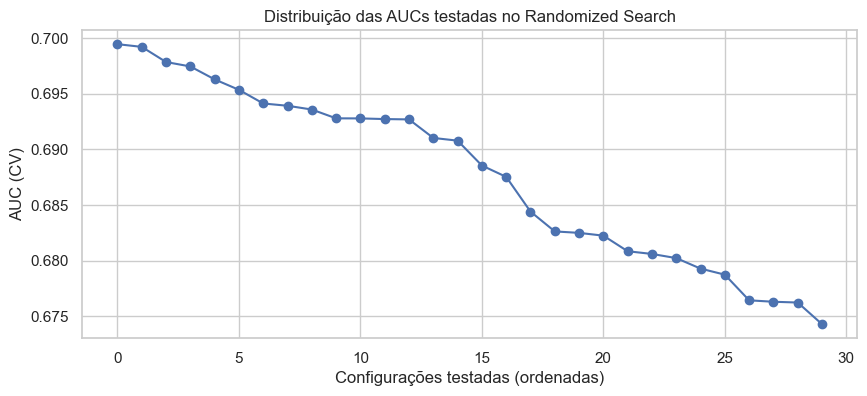

In [47]:
results_sorted = results.sort_values("mean_test_score", ascending=False)

plt.figure(figsize=(10, 4))
plt.plot(results_sorted["mean_test_score"].values, marker="o")
plt.title("Distribuição das AUCs testadas no Randomized Search")
plt.ylabel("AUC (CV)")
plt.xlabel("Configurações testadas (ordenadas)")
plt.grid(True)
plt.show()

In [48]:
results_sorted = results.sort_values("mean_test_score", ascending=False)

results_sorted[
    [
        "mean_test_score",
        "param_max_depth",
        "param_min_child_weight",
        "param_learning_rate",
        "param_subsample",
        "param_colsample_bytree",
    ]
].head(6)


,mean_test_score,param_max_depth,param_min_child_weight,param_learning_rate,param_subsample,param_colsample_bytree
13,0.699429,8,80,0.03,0.9,0.9
1,0.699186,8,80,0.03,0.7,0.7
25,0.697827,8,30,0.03,0.9,0.9
14,0.697429,8,30,0.03,0.8,0.8
17,0.696269,10,80,0.03,0.7,0.7
5,0.695332,10,50,0.03,0.8,0.9


Foi realizada uma busca aleatória restrita de hiperparâmetros, limitada a um espaço pequeno e guiado por boas práticas de modelagem em crédito, com o objetivo de melhorar marginalmente a performance sem comprometer a capacidade de generalização. Optou-se por Randomized Search em detrimento de Grid Search exaustivo para reduzir risco de overfitting e custo computacional

# Comparação dos modelos AS-IS e TO-BE

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_eval = df_test.copy()

# Score de Bom Pagador (OBRIGATÓRIO pelo enunciado)
df_eval["score"] = best_model.predict_proba(X_test)[:, 0]

valor_emprestimo = 1000


In [50]:
# Aprovação AS-IS
df_eval["aprovado_ASIS"] = (df_eval["IDADE"] > 28).astype(int)

# Percentual de negados
perc_negados_asis = 1 - df_eval["aprovado_ASIS"].mean()

perc_negados_asis


np.float64(0.17819945508299362)

In [51]:
carteira_asis = df_eval["aprovado_ASIS"].sum() * valor_emprestimo

divida_asis = (
    df_eval
    .query("aprovado_ASIS == 1 and TARGET == 1")
    .shape[0]
    * valor_emprestimo
)

carteira_asis, divida_asis


(np.int64(42529000), 9852000)

### Analisar esse cutoff score, provavelmente foi por isso que deu igual, o objetivo não é calcular com base no mesmo score, e sim com base no acerto do modelo, não faz sentido isso eu acho

In [52]:
cutoff_score = df_eval["score"].quantile(perc_negados_asis)
cutoff_score


np.float32(0.37093592)

In [53]:
df_eval["aprovado_TOBE"] = (df_eval["score"] >= cutoff_score).astype(int)

# Checagem (tem que bater)
1 - df_eval["aprovado_TOBE"].mean()


np.float64(0.17819945508299362)

In [54]:
carteira_tobe = df_eval["aprovado_TOBE"].sum() * valor_emprestimo

divida_tobe = (
    df_eval
    .query("aprovado_TOBE == 1 and TARGET == 1")
    .shape[0]
    * valor_emprestimo
)

carteira_tobe, divida_tobe


(np.int64(42529000), 8293000)

In [55]:
economia = divida_asis - divida_tobe
ganho_carteira = carteira_tobe - carteira_asis

print(f"Carteira AS-IS: R$ {carteira_asis:,.0f}")
print(f"Carteira TO-BE: R$ {carteira_tobe:,.0f}")
print("")
print(f"Dívida AS-IS:   R$ {divida_asis:,.0f}")
print(f"Dívida TO-BE:   R$ {divida_tobe:,.0f}")
print("")
print(f"Economia gerada: R$ {economia:,.0f}")
print(f"Ganho de carteira: R$ {ganho_carteira:,.0f}")


Carteira AS-IS: R$ 42,529,000
Carteira TO-BE: R$ 42,529,000

Dívida AS-IS:   R$ 9,852,000
Dívida TO-BE:   R$ 8,293,000

Economia gerada: R$ 1,559,000
Ganho de carteira: R$ 0


In [56]:
print("Negados AS-IS (%):", round(perc_negados_asis * 100, 2))
print(
    "Negados TO-BE (%):",
    round((1 - df_eval["aprovado_TOBE"].mean()) * 100, 2)
)

divida_tobe <= divida_asis



Negados AS-IS (%): 17.82
Negados TO-BE (%): 17.82


True

In [57]:
inad_asis = df_eval.query("aprovado_ASIS == 1")["TARGET"].mean()
inad_tobe = df_eval.query("aprovado_TOBE == 1")["TARGET"].mean()

print(f"Inadimplência AS-IS: {inad_asis:.2%}")
print(f"Inadimplência TO-BE: {inad_tobe:.2%}")


Inadimplência AS-IS: 23.17%
Inadimplência TO-BE: 19.50%
